# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the RY ansatz

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-05-04 19:47:42,654: Credentials are already in use. The existing account in the session will be replaced.


In [18]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [19]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [46]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [47]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [48]:
def initial_state_preparation(dist: float, mapper_str: str = "pa"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [49]:
inter_atomic_dists: list = np.arange(0.720, 0.755, 0.005)

In [8]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))
    

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.7200 Å 	 Electronic Ground Energy: -1.8721 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.7250 Å 	 Electronic Ground Energy: -1.8671 Eh 	Total Ground State Energy: -1.1372 Eh
Interatomic dist: 0.7300 Å 	 Electronic Ground Energy: -1.8622 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7350 Å 	 Electronic Ground Energy: -1.8573 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7400 Å 	 Electronic Ground Energy: -1.8524 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7450 Å 	 Electronic Ground Energy: -1.8475 Eh 	Total Ground State Energy: -1.1372 Eh
Interatomic dist: 0.7500 Å 	 Electronic Ground Energy: -1.8427 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.7550 Å 	 Electronic Ground Energy: -1.8379 Eh 	Total Ground State Energy: -1.1370 Eh


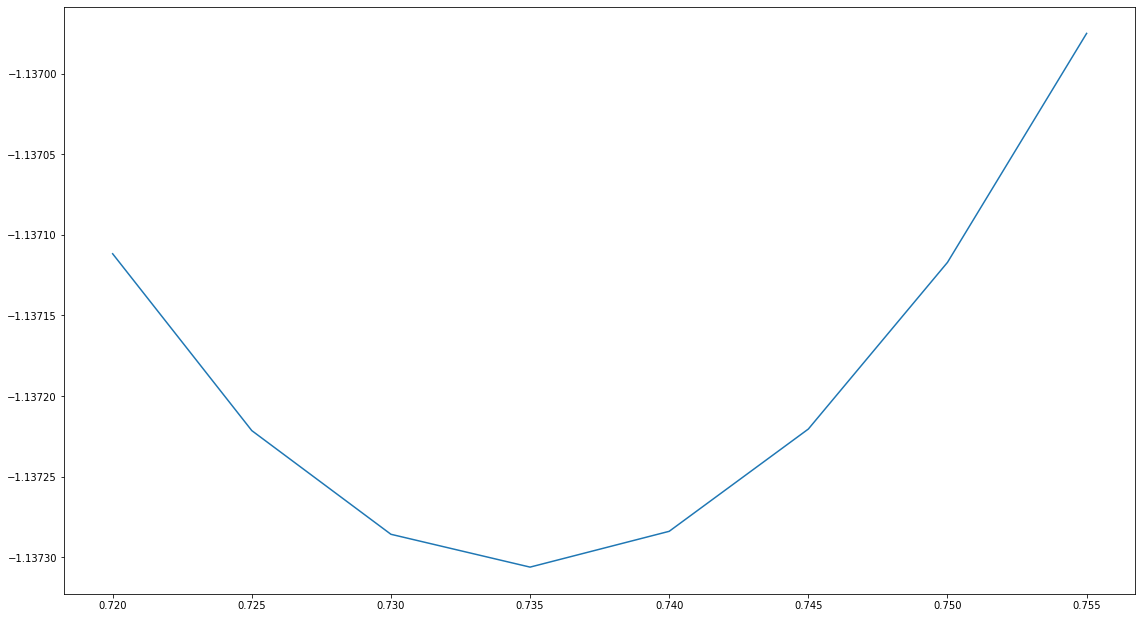

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.show()

In [50]:
ry_electronic_ground_energies: list = []
ry_nuclear_repulsion_energies: list = []
ry_total_ground_state_energies: list = []

from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
# counts = []
# values = []
# params = []
# deviation = []

# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_toronto')
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)
# optimizer = SLSQP(maxiter=5)
optimizer = COBYLA(maxiter=10000)
ansatz = 0

print("Total Ground State Energies of H2 Molecule using UCCSD ansatz\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "RY"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 2
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = rotation_blocks,
        entanglement_blocks = entanglement_blocks,
        entanglement=entanglement,
        reps=repetitions,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer=skip_final_rotation_layer,
        insert_barriers=True,
        name="RY"
    )

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    
    counts = []
    values = []
    params = []
    deviation = []

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=quantum_instance,
        callback=callback,
        initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    ry_total_ground_state_energies.append( np.real(result.eigenvalue) )
    # print(np.real(result.eigenvalue))
    

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 79,
    'eigenstate': array([ 3.84473787e-05+0.j,  9.93296776e-01+0.j, -1.15592012e-01+0.j,
        2.14283254e-05+0.j]),
    'eigenvalue': (-1.8378720276043319+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[4]): 0.0169235782361427,
                              ParameterVectorElement(θ[5]): -0.13612410787776819,
                              ParameterVectorElement(θ[3]): -0.05412901748953852,
                              ParameterVectorElement(θ[2]): 0.23116058478368465,
                              ParameterVectorElement(θ[1]): 0.07843249936704833,
                              ParameterVectorElement(θ[0]): -0.04817119763414022},
    'optimal_point': array([-0.0481712 ,  0.0784325 ,  0.23116058, -0.05412902,  0.01692358,
       -0.13612411]),
    'optimal_value': -1.8378720276043319,
    'optimizer_evals': None,
    'optimizer_time': 0.46538829803466797}


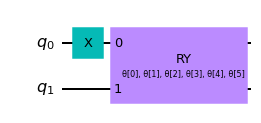

In [51]:
ansatz.draw("mpl")

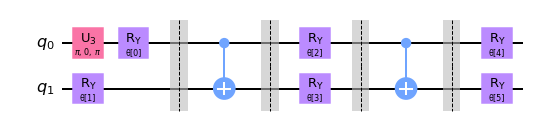

In [52]:
ansatz.decompose().draw("mpl")

In [53]:
# print(ry_total_ground_state_energies)

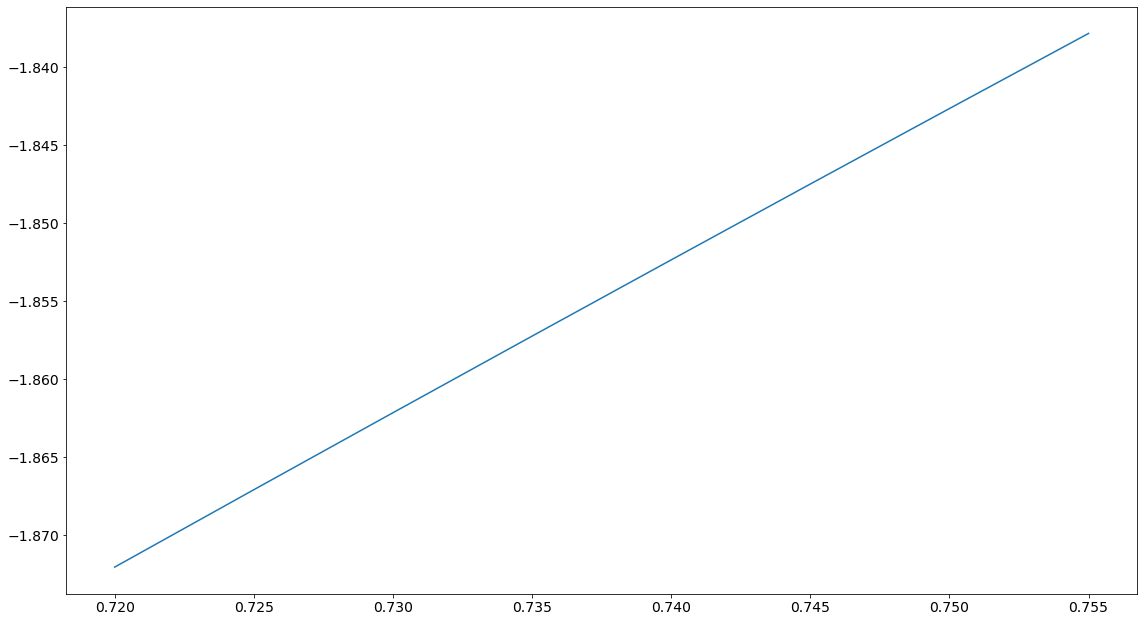

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(inter_atomic_dists, ry_total_ground_state_energies)
plt.show()

In [44]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    # 'energy (Ha)': energy,
    # 'error (mHa)': (energy-exact_energy)*1000,
    # 'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    # 'score': score
}

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,# of CNOTs
0,COBYLA,TwoLocal,2,6,[ry],cx,linear,2,2


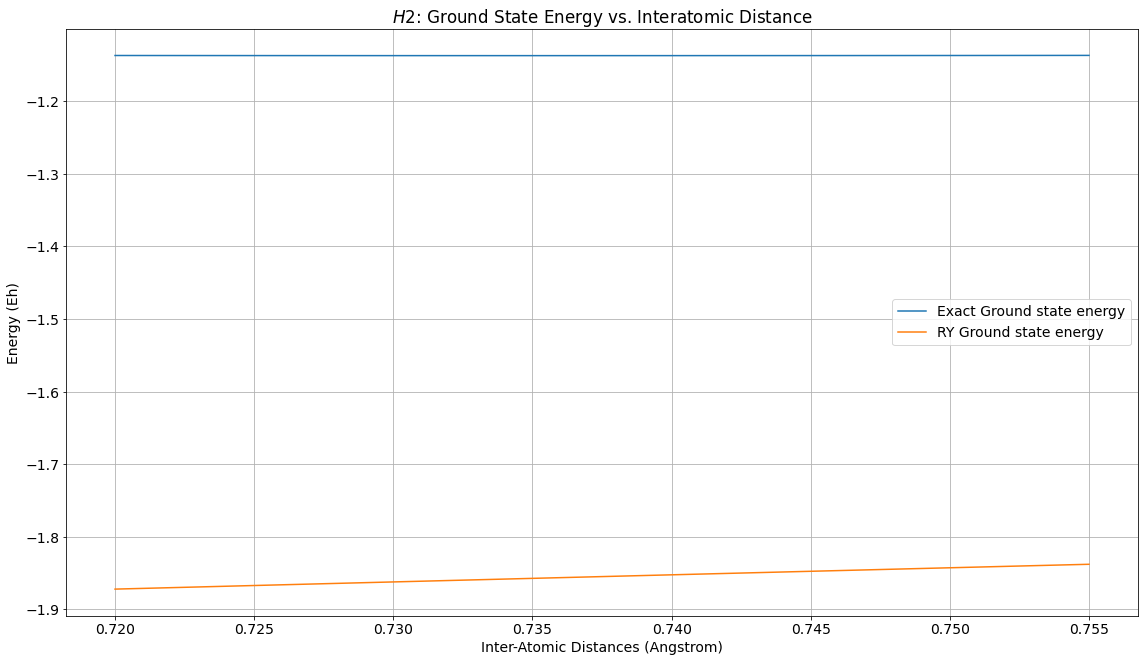

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

plt.title(r"$H2$: Ground State Energy vs. Interatomic Distance")

plt.rc('font', size=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

ax.set_xlabel('Inter-Atomic Distances (Angstrom)')
ax.set_ylabel('Energy (Eh)')
ax.grid()

plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies, label="Exact Ground state energy")
plt.plot(inter_atomic_dists, ry_total_ground_state_energies, label="RY Ground state energy")

plt.legend()

# fig_title = f"{result_dict['optimizer']}-{result_dict['mapping']}-{result_dict['ansatz']}.png"

fig.savefig("ry_vqe_h2_id_fig.png", dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',

    'entanglement', 'repetitions', "# of CNOTs"]]

# plt.show()